# Overview

In this notebook, I will compare predictions on the 2021 season from my final model against historical odds. Data for the historical odds was gathered from [Sportsbook Reviews Online](https://www.sportsbookreviewsonline.com/scoresoddsarchives/nhl/nhloddsarchives.htm). Per their website: Data is sourced from various online sportsbooks including 5dimes, BetOnline, Bookmaker, Heritage, Pinnacle Sports, Sportsbook.com as well as the Westgate Superbook in Las Vegas.

I will look at 2 simple betting strategies to determine profitability:

1. Bet 100 on every game where either the home or away team winning probability from my model is higher than the implied odds  
2. Bet to win 100 on every game where either the home or away team winning probability from my model is higher than the implied odds

# Data Cleaning and Merging

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

In [325]:
odds = pd.read_excel('data/nhl odds 2021.xlsx')

In [326]:
odds.head()

,Date,Rot,VH,Team,1st,2nd,3rd,Final,Open,Close,PuckLine,Unnamed: 11,OpenOU,Unnamed: 13,CloseOU,Unnamed: 15
0,113,41,V,Pittsburgh,1,1,1,3,-110,-115,1.5,-310,6.0,-110,6.0,105
1,113,42,H,Philadelphia,2,1,3,6,100,-105,-1.5,260,6.0,-110,6.0,-125
2,113,43,V,Montreal,2,1,1,0,132,120,1.5,-220,6.0,-110,6.0,-110
3,113,44,H,Toronto,1,2,1,1,-145,-140,-1.5,195,6.0,-110,6.0,-110
4,113,45,V,Chicago,0,0,1,1,230,210,1.5,-125,6.5,-110,6.5,-110


In [327]:
team_conversion =   { 'Anaheim': 'ANA', 
                      'Arizona' :'ARI', 
                      'Boston': 'BOS', 
                      'Buffalo':'BUF',
                      'Calgary': 'CGY', 
                      'Carolina': 'CAR', 
                      'Chicago': 'CHI', 
                      'Colorado': 'COL',
                     'Columbus': 'CBJ',
                     'Dallas': 'DAL',
                     'Detroit': 'DET',
                     'Edmonton': 'EDM',
                     'Florida': 'FLA',
                     'LosAngeles': 'L.A',
                     'Minnesota': 'MIN',
                     'Montreal': 'MTL',
                     'Nashville': 'NSH',
                     'NewJersey': 'N.J',
                     'NYIslanders': 'NYI',
                     'NYRangers': 'NYR',
                     'Ottawa': 'OTT',
                     'Philadelphia': 'PHI',
                     'Pittsburgh': 'PIT',
                     'SanJose': 'S.J',
                     'St.Louis': 'STL',
                     'TampaBay': 'T.B',
                     'Toronto': 'TOR',
                     'Vancouver': 'VAN',
                      'Vegas':'VGK',
                     'Washington': 'WSH',
                     'Winnipeg': 'WPG'}

In [328]:
#convert date to proper datestring and create team key
odds = odds.replace({'Team': team_conversion})
odds['Month'] = odds['Date'].apply(lambda x: '0'+str(x)[0])
odds['Day'] = odds['Date'].apply(lambda x: str(x)[1:])
odds['Year'] = 2021
odds['Datestring'] = odds[['Year','Month','Day']].astype(str).apply('-'.join, 1)       
odds['Team_Key'] = odds['Team'].astype(str)+'_'+odds['Datestring'].astype(str)
#calculate implied odds
odds['Implied_odds'] = np.where(odds['Close'] < 0, (odds['Close']*-1)/((odds['Close']*-1)+100) , 100/(odds['Close']+100))

In [329]:
odds.head(5)

,Date,Rot,VH,Team,1st,2nd,3rd,Final,Open,Close,PuckLine,Unnamed: 11,OpenOU,Unnamed: 13,CloseOU,Unnamed: 15,Month,Day,Year,Datestring,Team_Key,Implied_odds
0,113,41,V,PIT,1,1,1,3,-110,-115,1.5,-310,6.0,-110,6.0,105,01,13,2021,2021-01-13,PIT_2021-01-13,0.534884
1,113,42,H,PHI,2,1,3,6,100,-105,-1.5,260,6.0,-110,6.0,-125,01,13,2021,2021-01-13,PHI_2021-01-13,0.512195
2,113,43,V,MTL,2,1,1,0,132,120,1.5,-220,6.0,-110,6.0,-110,01,13,2021,2021-01-13,MTL_2021-01-13,0.454545
3,113,44,H,TOR,1,2,1,1,-145,-140,-1.5,195,6.0,-110,6.0,-110,01,13,2021,2021-01-13,TOR_2021-01-13,0.583333
4,113,45,V,CHI,0,0,1,1,230,210,1.5,-125,6.5,-110,6.5,-110,01,13,2021,2021-01-13,CHI_2021-01-13,0.322581


In [330]:
#import file with predictions
predictions = pd.read_csv('data/Predictions_2021')

In [331]:
#merge my predictions with odd df
df = predictions.merge(odds.loc[:,['Team_Key', 'Implied_odds', 'Close']].add_prefix('home_'), how = 'left', left_on = 'Home_Team_Key', right_on = 'home_Team_Key').drop(columns = 'home_Team_Key')
df = df.merge(odds.loc[:,['Team_Key', 'Implied_odds', 'Close']].add_prefix('away_'), how = 'left', left_on = 'Away_Team_Key', right_on = 'away_Team_Key').drop(columns = 'away_Team_Key')

In [332]:
#odds info only contains info for games up to 5/4. These are the 15 missing games below. 
df.isna().sum()

Unnamed: 0                      0
game_id                         0
date                            0
venue                           0
home_team                       0
away_team                       0
start_time                      0
home_score                      0
away_score                      0
status                          0
Home_Team_Won                   0
Home_Team_Key                   0
Away_Team_Key                   0
home_Game_Number                0
away_Game_Number                0
home_goalie                     0
home_Goalie_FenwickSV%          0
home_Goalie_GSAx/60             0
home_Goalie_HDCSV%              0
away_goalie                     0
away_Goalie_FenwickSV%          0
away_Goalie_GSAx/60             0
away_Goalie_HDCSV%              0
home_last_40_FF%_5v5            0
home_last_40_GF%_5v5            0
home_last_40_xGF%_5v5           0
home_last_40_SH%                0
home_last40_pp_TOI_per_game     0
home_last40_xGF_per_min_pp      0
home_last40_GF

In [333]:
#drop missing games from df
df = df.dropna()

In [334]:
conditions = [df['Home Win Probability'] > df['home_Implied_odds'],
                df['Away Win Probability'] > df['away_Implied_odds']
                 ]
    

choices = ['Home', 
          'Away']

df['Bet'] = np.select(conditions, choices, default = 'No Bet')


In [337]:
df['Favorites'] = np.where(df['home_Implied_odds'] >df['away_Implied_odds'], 'Home', 'Away' )
conditions = [df['Bet'] == 'No Bet',
              df['Bet'] == df['Favorites'],
              df['Bet'] != df['Favorites']
    
    
]
choices = ['No Bet',
           'Favorite',
           'Underdog'
    ]

df['Bet_For'] = np.select(conditions, choices)

In [340]:
#calculate profit for 100$ per game strat
conditions = [((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close'] <0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']<0)),
                ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']>0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [-100 * (100/df['home_Close']), 
           df['home_Close'],
          -100 * (100/df['away_Close']),
          df['away_Close'],
          0]

df['Profit_Strat1'] = np.select(conditions, choices, default = -100)

In [341]:
#calculate profit for bet to win 100$ strat
conditions = [((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close'] <0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 1) & (df['home_Close']>0)),
               ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 0) & (df['home_Close']>0)),
              ((df['Bet'] == 'Home') & (df['Home_Team_Won'] == 0) & (df['home_Close']<0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']<0)),
                ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 0) & (df['away_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 1) & (df['away_Close']>0)),
              ((df['Bet'] == 'Away') & (df['Home_Team_Won'] == 1) & (df['away_Close']<0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [100, 
           100,
          (100/df['home_Close'])*-100,
           df['home_Close'],
           100,
           100,
             (100/df['away_Close'])*-100,
          df['away_Close'],
          0]

df['Profit_Strat2'] = np.select(conditions, choices)

In [342]:
#cost of bet to win 100$ strat
conditions = [((df['Bet'] == 'Home') & (df['home_Close']>0)),
              ((df['Bet'] == 'Home') & (df['home_Close']<0)),
              ((df['Bet'] == 'Away') &  (df['away_Close']>0)),
              ((df['Bet'] == 'Away') &  (df['away_Close']<0)),
              df['Bet'] == 'No Bet'
                 ]
    

choices = [(100/df['home_Close'])*100,
           df['home_Close']*-1,
             (100/df['away_Close'])*100,
          df['away_Close']*-1,
          0]

df['Cost_Strat2'] = np.select(conditions, choices)

In [370]:
#convert date to pandas datetime
df['date'] = pd.to_datetime(df['date'])

In [352]:
#calculate cumulative profit for poth strategies
df['Profit_Strat2_cumsum'] = df['Profit_Strat2'].cumsum()
df['Profit_Strat1_cumsum'] = df['Profit_Strat1'].cumsum()

In [357]:
df['Won_Bet'] = np.where(df['Profit_Strat2'] > 0, 1, 0)

In [371]:
df.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_Game_Number,away_Game_Number,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_GF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,home_last40_GA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_GF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,away_last40_GA_per_min_pk,home_Rating.A.Pre,away_Rating.A.Pre,B2B_Status,Prediction,Away Win Probability,Home Win Probability,home_Implied_odds,home_Close,away_Implied_odds,away_Close,Bet,Favorites,Bet_For,Profit_Strat1,Profit_Strat2,Cost_Strat2,Profit_Strat2_cumsum,Profit_Strat1_cumsum,Won_Bet
0,3626,2020020001,2021-01-13,Wells Fargo Center,PHI,PIT,2021-01-13 22:30:00,6,3,Final,1,PHI_2021-01-13,PIT_2021-01-13,1.0,1.0,Carter Hart,0.936798,-0.097290,0.869565,Tristan Jarry,0.937063,-0.291447,0.834711,51.037671,55.248131,50.833631,10.024139,5.216250,0.104625,0.134196,5.579583,0.088716,0.112016,49.490424,49.414366,49.580182,8.701463,5.068333,0.122230,0.143045,4.693750,0.094008,0.111851,1531.48,1514.01,Neither,1,0.438607,0.561393,0.512195,-105.0,0.534884,-115.0,Home,Away,Underdog,95.238095,100.0,105.0,100.0,95.238095,1
1,3627,2020020003,2021-01-13,Scotiabank Arena,TOR,MTL,2021-01-14 00:00:00,5,4,Final,1,TOR_2021-01-13,MTL_2021-01-13,1.0,1.0,Frederik Andersen,0.936070,-0.305563,0.866051,Carey Price,0.930668,-0.444146,0.862233,50.926333,51.613248,52.907871,9.385230,4.490833,0.102876,0.161440,4.251250,0.095972,0.117612,54.275967,49.447384,54.826724,6.807514,4.443333,0.093567,0.090023,5.106250,0.115594,0.112607,1516.52,1497.57,Neither,1,0.404786,0.595214,0.583333,-140.0,0.454545,120.0,Home,Home,Favorite,71.428571,100.0,140.0,200.0,166.666667,1
2,3628,2020020002,2021-01-13,Amalie Arena,T.B,CHI,2021-01-14 01:00:00,5,1,Final,1,T.B_2021-01-13,CHI_2021-01-13,1.0,1.0,Andrei Vasilevskiy,0.941531,-0.023160,0.876847,Malcolm Subban,0.923432,-0.589420,0.857809,53.085863,60.496256,55.396941,9.975409,5.086667,0.095347,0.098296,5.632500,0.101065,0.106525,49.003131,51.252598,47.514358,9.212376,5.646667,0.107010,0.084120,4.739583,0.103226,0.089670,1584.31,1492.13,Neither,1,0.320753,0.679246,0.714286,-250.0,0.322581,210.0,No Bet,Home,No Bet,0.000000,0.0,0.0,200.0,166.666667,0
3,3629,2020020004,2021-01-13,Rogers Place,EDM,VAN,2021-01-14 03:00:00,3,5,Final,0,EDM_2021-01-13,VAN_2021-01-13,1.0,1.0,Mikko Koskinen,0.938316,-0.009204,0.867299,Braden Holtby,0.927771,-0.408527,0.852194,48.540721,47.474864,48.384948,8.348491,4.868750,0.111322,0.154044,4.358333,0.114551,0.103250,47.274508,48.647099,46.039131,8.973817,5.262917,0.098805,0.128256,5.131250,0.110110,0.116931,1490.93,1510.30,Neither,1,0.418404,0.581596,0.600000,-150.0,0.434783,130.0,No Bet,Home,No Bet,0.000000,0.0,0.0,200.0,166.666667,0
4,3630,2020020005,2021-01-13,Ball Arena,COL,STL,2021-01-14 03:30:00,1,4,Final,0,COL_2021-01-13,STL_2021-01-13,1.0,1.0,Philipp Grubauer,0.938738,-0.054610,0.852300,Jordan Binnington,0.936047,-0.058439,0.891566,54.173584,55.777256,54.433969,8.037510,5.254167,0.107819,0.118953,4.904583,0.115045,0.091751,53.469034,58.414704,53.596844,8.848351,4.181250,0.128311,0.161435,4.751667,0.124851,0.142055,1549.43,1526.11,Neither,1,0.449294,0.550706,0.591837,-145.0,0.444444,125.0,Away,Home,Underdog,125.000000,100.0,80.0,300.0,291.666667,1


---

# Evaluation
Let's check the log loss from the implied odds. My model's log loss on the 2021 season was 0.655967. So the book implied odds are still performing slightly better with a log loss of 0.6529

In [368]:
from sklearn.metrics import log_loss, accuracy_score

io_list = []

for index, row in df.iterrows():
    io_list.append([row['away_Implied_odds'], row['home_Implied_odds']])
    

log_loss(copy['Home_Team_Won'], io_list)

0.6529358923310422

How many bets would be for home vs away vs no bet? My model is definitley favoring the home team. From the EDA notebook, The home team had won 56.0% in the 17-18 season, 53.7% in 18-19, 53.1% in 19-20 and only 52.7% in 20-21 season. THe 20-21 season having no fans may be affecting this outcome for the home team and may have hurt the model slightly for the 20-21 season.

In [335]:
df['Bet'].value_counts()

Home      455
Away      220
No Bet    130
Name: Bet, dtype: int64

In [336]:
df['Bet'].value_counts(normalize = True)

Home      0.565217
Away      0.273292
No Bet    0.161491
Name: Bet, dtype: float64

How many bets were for the favorite vs the underdrog? Interestingly the model liked underdogs more often. 

In [369]:
df['Bet_For'].value_counts(normalize = 'True')

Underdog    0.498137
Favorite    0.340373
No Bet      0.161491
Name: Bet_For, dtype: float64

The strategy of betting to win 100$ resulted in a per bet ROI of 1.62%

In [343]:
#ROI per bet
df['Profit_Strat2'].sum() / df['Cost_Strat2'].sum()

0.016214765368195147

Total profit for this strategy would have been $1,176.51

In [359]:
#total profit
df['Profit_Strat2'].sum()

1176.5146909843343

The strategy was profitable initially and never dipped down into the red. You would have only needed an initial bankroll of $325 to implement this.

In [361]:
#initial bankroll needed 
df[df['date'] == '2021-01-13']['Cost_Strat2'].sum()

325.0

I would have won only 49% of bets, but since the marjority of bets were for the underdog, the lower costs benefited profitability. 

In [358]:
df[df['Bet'] != 'No Bet']['Won_Bet'].value_counts(normalize = True)

0    0.511111
1    0.488889
Name: Won_Bet, dtype: float64

Strategy 1, bet 100$ every bettable game was ultimately not profitable.

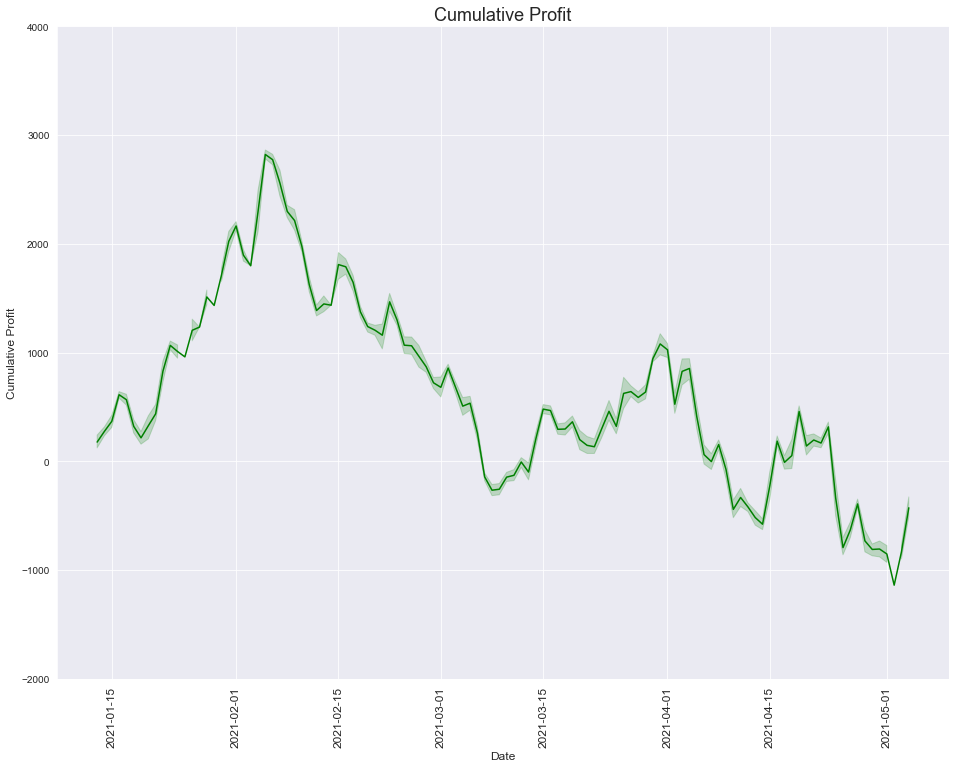

In [355]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = df['date'], y = df['Profit_Strat1_cumsum'], color = 'green')
ax.set_title('Cumulative Profit', fontsize = 18)
ax.set_ylabel('Cumulative Profit', fontsize =12, )
ax.set_xlabel('Date', fontsize =12)
plt.xticks(rotation='vertical', fontsize = 12)
# ax.axhline(325, linestyle = 'dashed', label = 'Initial Bankroll: $325', color = 'black')
ax.set_ylim(-2000,4000)



plt.show()

Strategy 2, bet to win 100$ on every bettable game, was profitbale

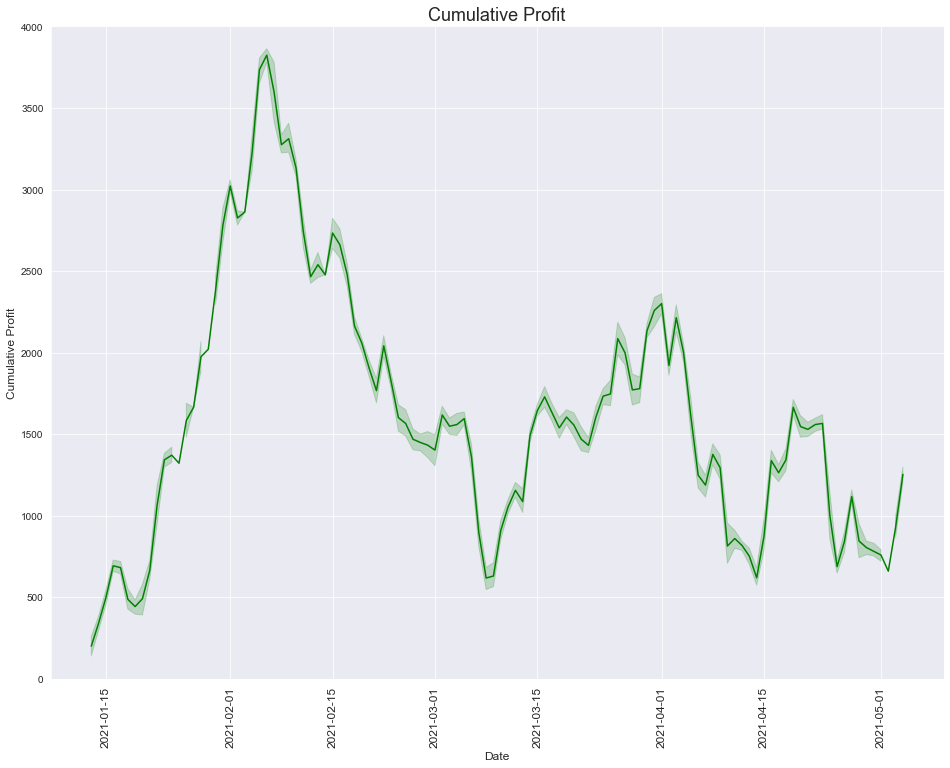

In [348]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = df['date'], y = df['Profit_Strat2_cumsum'], color = 'green')
ax.set_title('Cumulative Profit', fontsize = 18)
ax.set_ylabel('Cumulative Profit', fontsize =12, )
ax.set_xlabel('Date', fontsize =12)
plt.xticks(rotation='vertical', fontsize = 12)
# ax.axhline(325, linestyle = 'dashed', label = 'Initial Bankroll: $325', color = 'black')
ax.set_ylim(0,4000)



plt.show()

In [347]:
strat2 = pd.DataFrame(df.groupby('date').agg({'Profit_Strat2': 'sum'})).reset_index()

strat2['Cumulative Profit'] = strat2['Profit_Strat2'].cumsum()

strat2['date'] = pd.to_datetime(strat2['date'])

In [349]:
strat2.head()

,date,Profit_Strat2,Cumulative Profit
0,2021-01-13,300.000000,300.000000
1,2021-01-14,20.500000,320.500000
2,2021-01-15,175.357143,495.857143
3,2021-01-16,223.664122,719.521265
4,2021-01-17,-75.757576,643.763689


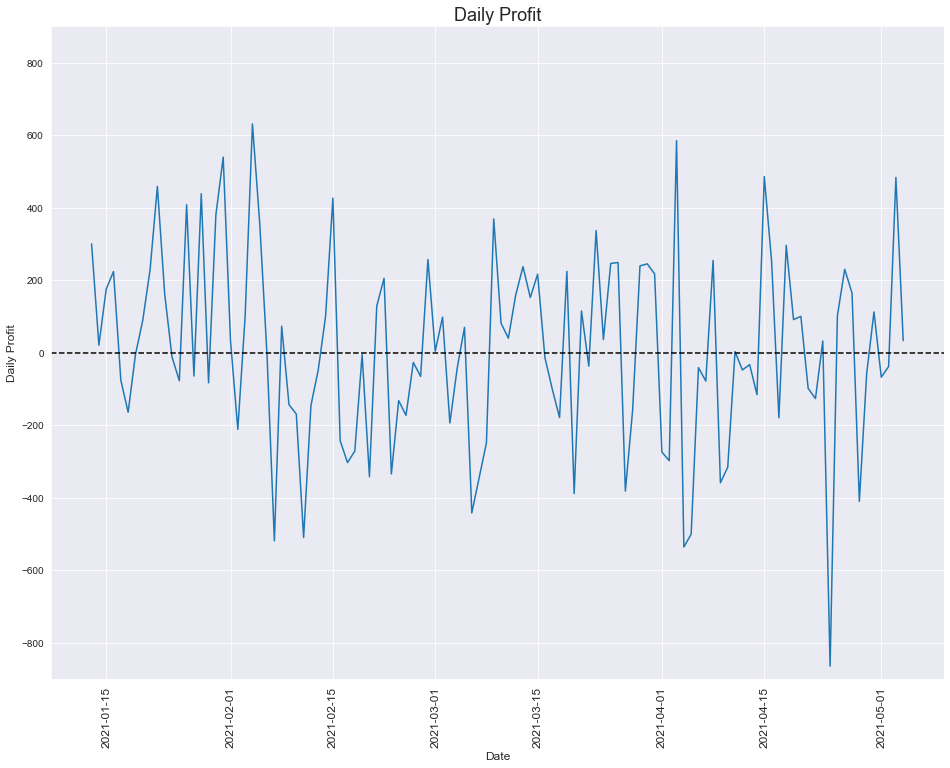

In [351]:
fig, ax = plt.subplots(figsize = (16,12))

ax = sns.lineplot(x = strat2['date'], y = strat2['Profit_Strat2'], palette = 'Blues')
ax.set_title('Daily Profit', fontsize = 18)
ax.set_ylabel('Daily Profit', fontsize =12, )
ax.set_xlabel('Date', fontsize =12)
plt.xticks(rotation='vertical', fontsize = 12)
ax.axhline(0, color = 'black', linestyle = 'dashed')
ax.set_ylim(-900,900)
plt.show()